In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import json
import cv2
import numpy as np

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
class KeypointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, "r") as f:
            self.data = json.load(f)

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        img = cv2.imread(f"{self.img_dir}/{item['id']}.png")
        h,w = img.shape[:2]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)
        kps = np.array(item['kps']).flatten()
        kps = kps.astype(np.float32)

        kps[::2] *= 224.0 / w # Adjust x coordinates
        kps[1::2] *= 224.0 / h # Adjust y coordinates

        return img, kps

In [28]:
train_dataset = KeypointsDataset("data/images","data/data_train.json")
val_dataset = KeypointsDataset("data/images","data/data_val.json")

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)


In [29]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc =  torch.nn.Linear(model.fc.in_features, 14*2) # Replaces the last layer

In [30]:
model = model.to(device)

In [31]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [32]:
+epochs=20
for epoch in range(epochs):
    for i, (imgs,kps) in enumerate(train_loader):
        imgs = imgs.to(device)
        kps = kps.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, kps)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, iter {i}, loss: {loss.item()}")

Epoch 0, iter 0, loss: 14213.1689453125
Epoch 0, iter 10, loss: 15353.7294921875
Epoch 0, iter 20, loss: 13941.1123046875
Epoch 0, iter 30, loss: 14170.4775390625
Epoch 0, iter 40, loss: 12948.15234375
Epoch 0, iter 50, loss: 13337.34765625
Epoch 0, iter 60, loss: 12530.1103515625
Epoch 0, iter 70, loss: 11769.181640625
Epoch 0, iter 80, loss: 11767.7724609375
Epoch 0, iter 90, loss: 10919.890625
Epoch 0, iter 100, loss: 11569.736328125
Epoch 0, iter 110, loss: 10169.125
Epoch 0, iter 120, loss: 11106.373046875
Epoch 0, iter 130, loss: 9761.154296875
Epoch 0, iter 140, loss: 9507.576171875
Epoch 0, iter 150, loss: 9413.26953125
Epoch 0, iter 160, loss: 9255.4404296875
Epoch 0, iter 170, loss: 9130.625
Epoch 0, iter 180, loss: 8493.037109375
Epoch 0, iter 190, loss: 8654.228515625
Epoch 0, iter 200, loss: 7655.4833984375
Epoch 0, iter 210, loss: 7765.6708984375
Epoch 0, iter 220, loss: 7306.779296875
Epoch 0, iter 230, loss: 7450.8955078125
Epoch 0, iter 240, loss: 6560.85498046875
Epoc

In [33]:
torch.save(model.state_dict(), "keypoints_model.pth")

In [34]:
# Import additional libraries for visualization
import matplotlib.pyplot as plt
from PIL import Image
import random

In [35]:
# Function to visualize keypoints on original image
def visualize_keypoints(dataset, idx, title="Keypoints Visualization"):
    """
    Visualize keypoints on the original image before preprocessing
    """
    # Get the original data
    item = dataset.data[idx]
    img_path = f"{dataset.img_dir}/{item['id']}.png"
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    # Get keypoints
    kps = np.array(item['kps']).reshape(-1, 2)  # Reshape to (num_points, 2)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    
    # Plot keypoints
    for i, (x, y) in enumerate(kps):
        plt.plot(x, y, 'ro', markersize=8, markerfacecolor='red', markeredgecolor='white', markeredgewidth=2)
        plt.text(x+5, y-5, str(i), color='white', fontsize=12, fontweight='bold')
    
    plt.title(f"{title} - Image: {item['id']}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"Image shape: {img.shape}")
    print(f"Number of keypoints: {len(kps)}")
    print(f"Keypoints shape: {kps.shape}")

In [36]:
# Function to visualize preprocessed data from DataLoader
def visualize_preprocessed_data(dataloader, num_samples=4):
    """
    Visualize preprocessed images and keypoints from the DataLoader
    """
    # Get one batch
    imgs, kps = next(iter(dataloader))
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(min(num_samples, len(imgs))):
        # Denormalize the image for visualization
        img = imgs[i].clone()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy and transpose for matplotlib
        img_np = img.permute(1, 2, 0).numpy()
        
        # Get keypoints and reshape
        keypoints = kps[i].numpy().reshape(-1, 2)
        
        # Plot
        axes[i].imshow(img_np)
        for j, (x, y) in enumerate(keypoints):
            axes[i].plot(x, y, 'ro', markersize=6, markerfacecolor='red', markeredgecolor='white', markeredgewidth=1)
            axes[i].text(x+2, y-2, str(j), color='white', fontsize=10, fontweight='bold')
        
        axes[i].set_title(f'Preprocessed Sample {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [37]:
# Test function to compare model predictions with ground truth
def test_model_predictions(model, dataloader, device, num_samples=2):
    """
    Test the trained model and visualize predictions vs ground truth
    """
    model.eval()
    
    with torch.no_grad():
        imgs, true_kps = next(iter(dataloader))
        imgs = imgs.to(device)
        
        # Get predictions
        pred_kps = model(imgs)
        
        # Move back to CPU for visualization
        imgs = imgs.cpu()
        pred_kps = pred_kps.cpu()
        
        fig, axes = plt.subplots(num_samples, 2, figsize=(12, 6*num_samples))
        if num_samples == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(min(num_samples, len(imgs))):
            # Denormalize image
            img = imgs[i].clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img = img * std + mean
            img = torch.clamp(img, 0, 1)
            img_np = img.permute(1, 2, 0).numpy()
            
            # Get keypoints
            true_keypoints = true_kps[i].numpy().reshape(-1, 2)
            pred_keypoints = pred_kps[i].numpy().reshape(-1, 2)
            
            # Plot ground truth
            axes[i, 0].imshow(img_np)
            for j, (x, y) in enumerate(true_keypoints):
                axes[i, 0].plot(x, y, 'go', markersize=6, markerfacecolor='green', markeredgecolor='white', markeredgewidth=1)
                axes[i, 0].text(x+2, y-2, str(j), color='white', fontsize=10, fontweight='bold')
            axes[i, 0].set_title(f'Ground Truth - Sample {i+1}')
            axes[i, 0].axis('off')
            
            # Plot predictions
            axes[i, 1].imshow(img_np)
            for j, (x, y) in enumerate(pred_keypoints):
                axes[i, 1].plot(x, y, 'ro', markersize=6, markerfacecolor='red', markeredgecolor='white', markeredgewidth=1)
                axes[i, 1].text(x+2, y-2, str(j), color='white', fontsize=10, fontweight='bold')
            axes[i, 1].set_title(f'Predictions - Sample {i+1}')
            axes[i, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Calculate and print loss
        loss = torch.nn.MSELoss()(pred_kps, true_kps)
        print(f"MSE Loss on sample batch: {loss.item():.6f}")

Testing dataset loading and visualization...

--- Sample 1 (Index: 1288) ---


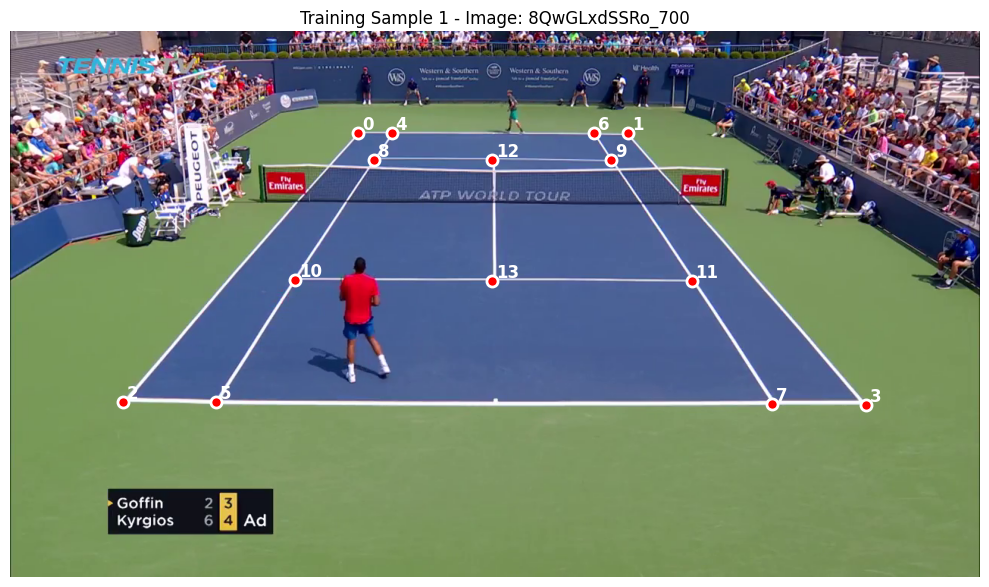

Image shape: (720, 1280, 3)
Number of keypoints: 14
Keypoints shape: (14, 2)

--- Sample 2 (Index: 675) ---


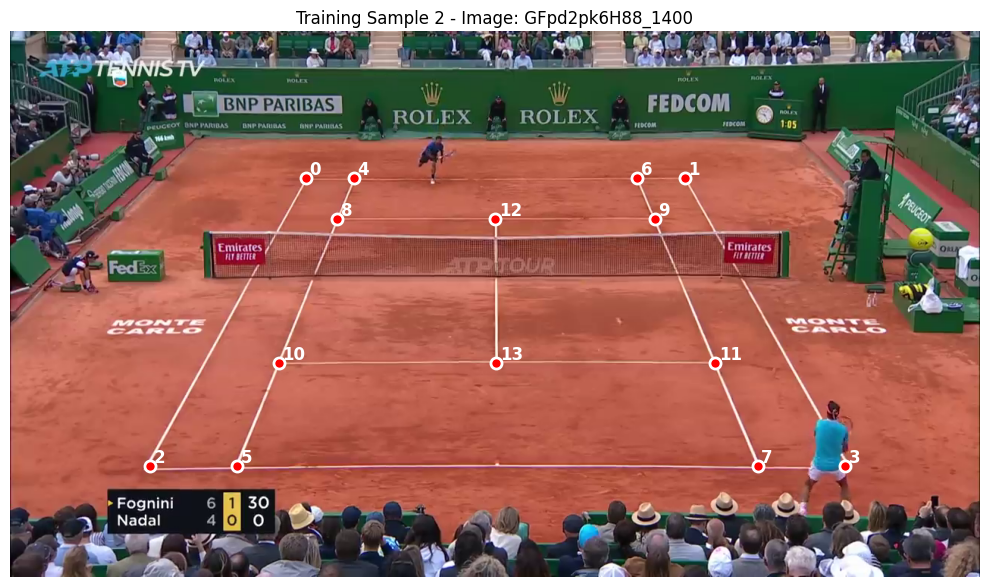

Image shape: (720, 1280, 3)
Number of keypoints: 14
Keypoints shape: (14, 2)

--- Sample 3 (Index: 6272) ---


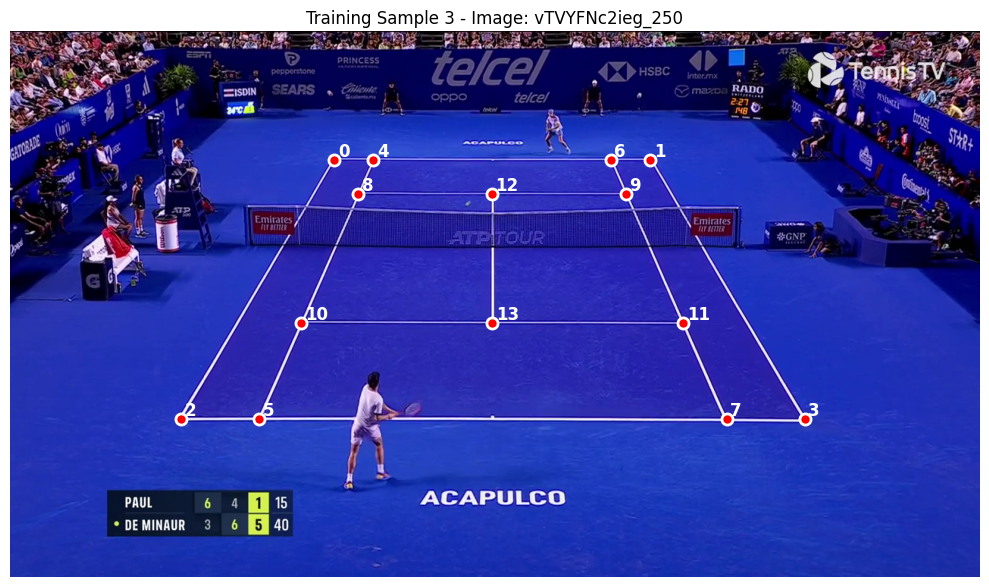

Image shape: (720, 1280, 3)
Number of keypoints: 14
Keypoints shape: (14, 2)


In [38]:
# Test the dataset and visualize original keypoints
print("Testing dataset loading and visualization...")

# Visualize a few random samples from training dataset
sample_indices = random.sample(range(len(train_dataset)), 3)
for i, idx in enumerate(sample_indices):
    print(f"\n--- Sample {i+1} (Index: {idx}) ---")
    visualize_keypoints(train_dataset, idx, f"Training Sample {i+1}")

Testing DataLoader and preprocessed data...


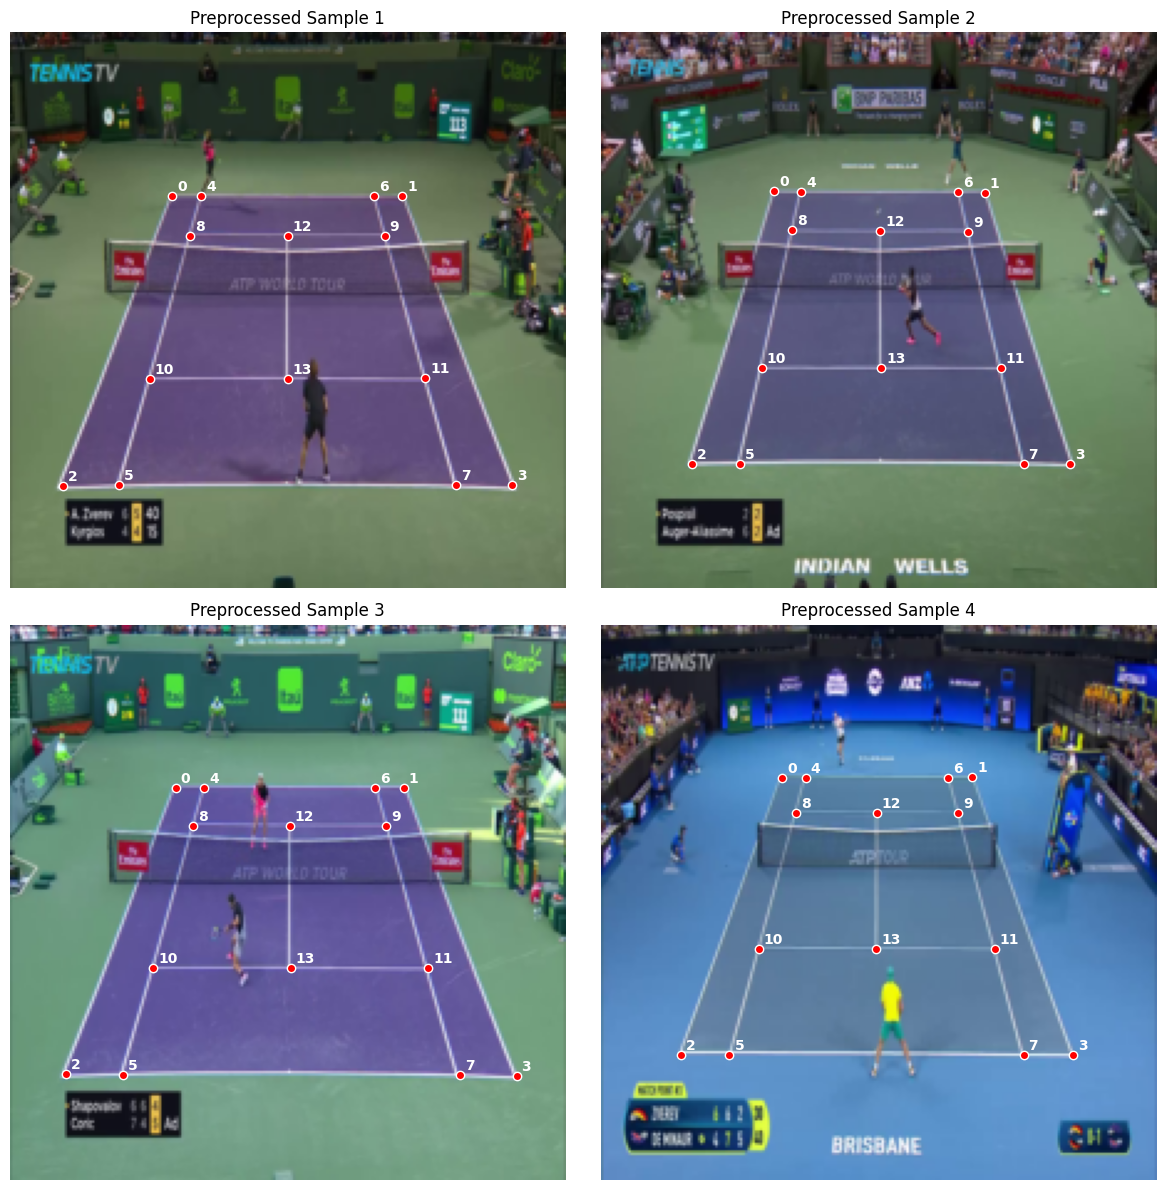

In [39]:
# Test the DataLoader and visualize preprocessed data
print("Testing DataLoader and preprocessed data...")
visualize_preprocessed_data(train_loader, num_samples=4)

Testing model predictions...
Note: Run this cell after training the model!


C:\Users\swaya\AppData\Local\Temp\ipykernel_21096\2250051563.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("keypoints_model.pth", map_

Loaded trained model successfully!


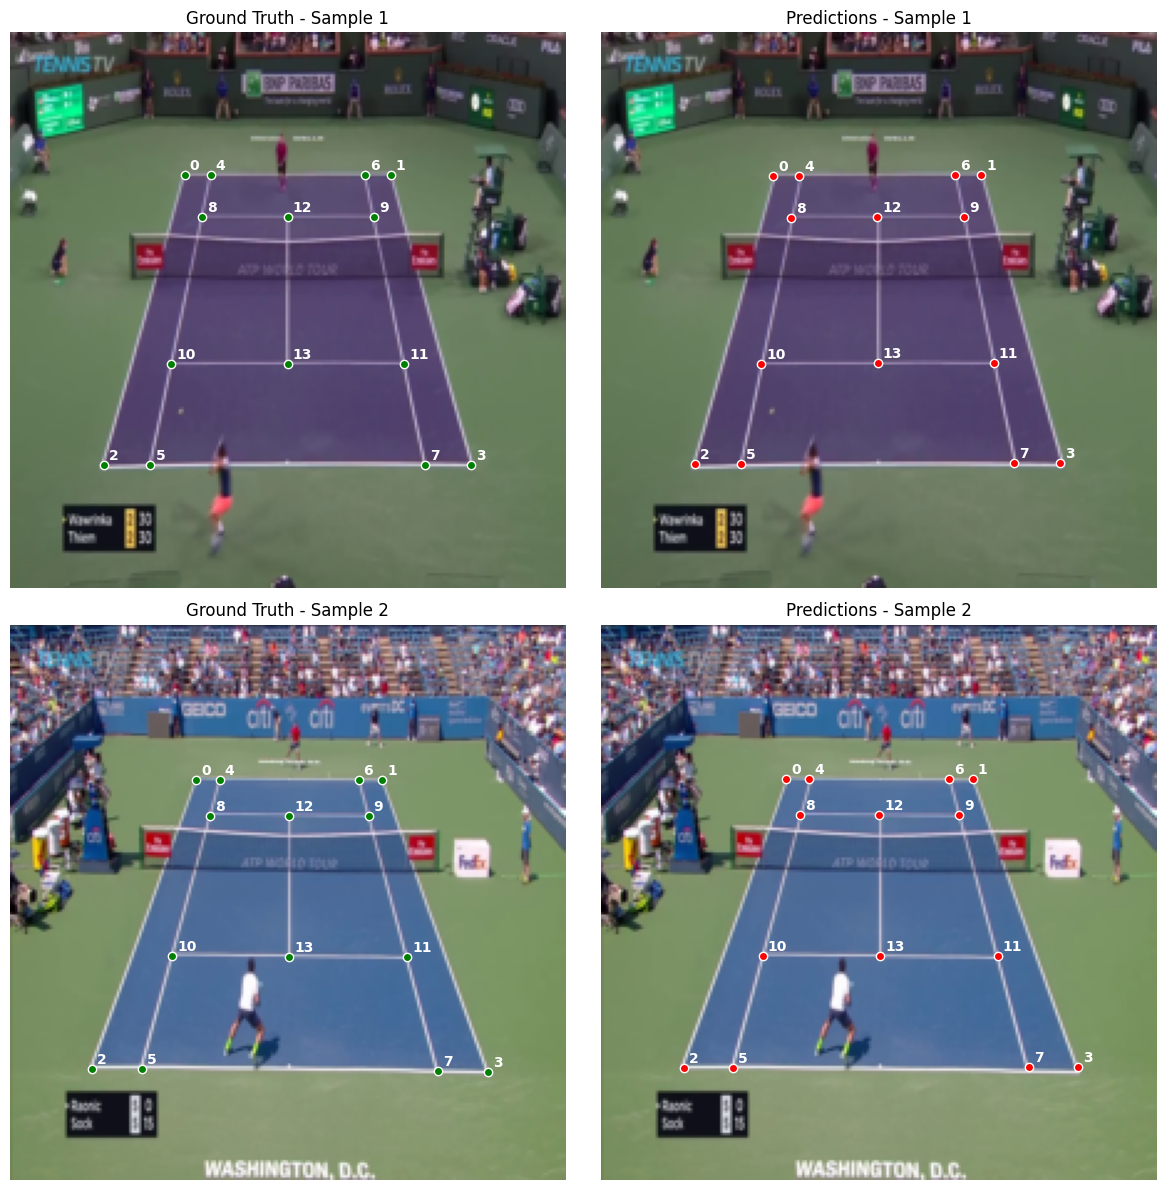

MSE Loss on sample batch: 0.683116


In [40]:
# Test model predictions (run this after training)
print("Testing model predictions...")
print("Note: Run this cell after training the model!")

# Load the trained model if it exists
try:
    model.load_state_dict(torch.load("keypoints_model.pth", map_location=device))
    print("Loaded trained model successfully!")
    
    # Test on validation data
    test_model_predictions(model, val_loader, device, num_samples=2)
    
except FileNotFoundError:
    print("Model file not found. Please train the model first by running all previous cells.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("You can still test with the untrained model, but predictions will be random:")

In [41]:
# Additional dataset statistics and info
print("=== Dataset Information ===")
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Batch size: {train_loader.batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Sample one item to check data structure
sample_img, sample_kps = train_dataset[0]
print(f"\nSample data shapes:")
print(f"Image shape: {sample_img.shape}")
print(f"Keypoints shape: {sample_kps.shape}")
print(f"Number of keypoints: {len(sample_kps) // 2}")

# Check data ranges
print(f"\nKeypoints range: [{sample_kps.min():.2f}, {sample_kps.max():.2f}]")
print(f"Image tensor range: [{sample_img.min():.3f}, {sample_img.max():.3f}]")

=== Dataset Information ===
Training dataset size: 6630
Validation dataset size: 2211
Batch size: 8
Number of training batches: 829
Number of validation batches: 277

Sample data shapes:
Image shape: torch.Size([3, 224, 224])
Keypoints shape: (28,)
Number of keypoints: 14

Keypoints range: [42.35, 185.15]
Image tensor range: [-2.118, 2.640]
